In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import torchvision
from tqdm import tqdm

In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available else "cpu"

In [ ]:
import os
import shutil
from torchvision.datasets import Food101

# Paths
base_dir = "data/food101"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

# Download the dataset using torchvision
dataset = Food101(root=base_dir, download=True)

# The raw images are stored in: data/food101/food-101/images/{class_name}/{image_name}.jpg
image_root = os.path.join(base_dir, 'food-101', 'images')

# The training and testing image lists are stored in these .txt files
meta_root = os.path.join(base_dir, 'food-101', 'meta')
train_list_file = os.path.join(meta_root, 'train.txt')
test_list_file = os.path.join(meta_root, 'test.txt')

# Function to move images to train/test folder structures
def organize_dataset(file_list, split_dir):
    with open(file_list, 'r') as f:
        image_paths = f.read().splitlines()

    for path in tqdm(image_paths, desc=f"Copying to {split_dir}"):
        class_name = path.split('/')[0] # Taking down class names
        img_name = path.split('/')[1] + '.jpg' # image names of respective class
        src_path = os.path.join(image_root, class_name, img_name) # The original class name with its image
        dst_dir = os.path.join(split_dir, class_name)
        os.makedirs(dst_dir, exist_ok=True) # train and test directories created with class folders
        dst_path = os.path.join(dst_dir, img_name)
        shutil.copy(src_path, dst_path) # The original class name with its images copied to destination folder

# Organize train and test datasets
organize_dataset(train_list_file, train_dir)
organize_dataset(test_list_file, test_dir)

print("Dataset organized into train/ and test/ folders.")


100%|██████████| 5.00G/5.00G [04:00<00:00, 20.8MB/s]
Copying to data/food101/test: 100%|██████████| 25250/25250 [00:40<00:00, 615.87it/s]

Dataset organized into train/ and test/ folders.


Random image path: data/food101/test/edamame/2542651.jpg
Image class: edamame
Image height: 512
Image width: 512


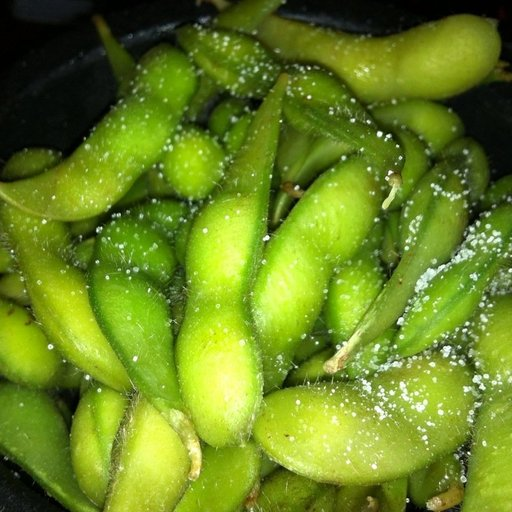

In [ ]:
# Visualize a random image
import random
from PIL import Image
from pathlib import Path

random.seed(42)
# Set image_root to the base directory where train and test folders are located
image_root = Path("data/food101")
# Adjust glob pattern to find .jpg files within any two levels of subdirectories
image_path_list = list(image_root.glob("*/*/*.jpg"))
random_image_path = random.choice(image_path_list)
img_class_name = random_image_path.parent.stem
img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {img_class_name}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

In [ ]:
# Set train and test transformations
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

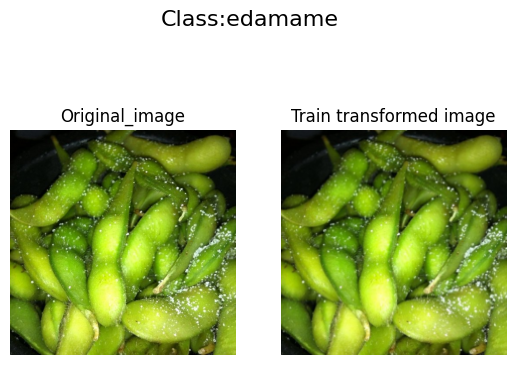

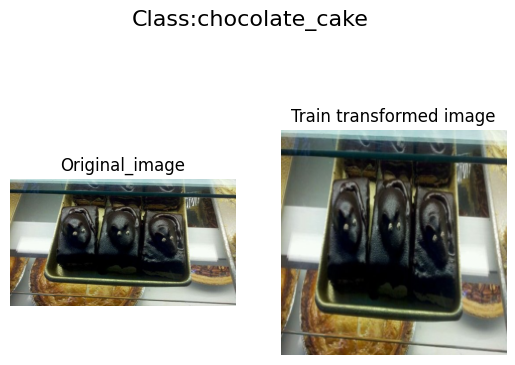

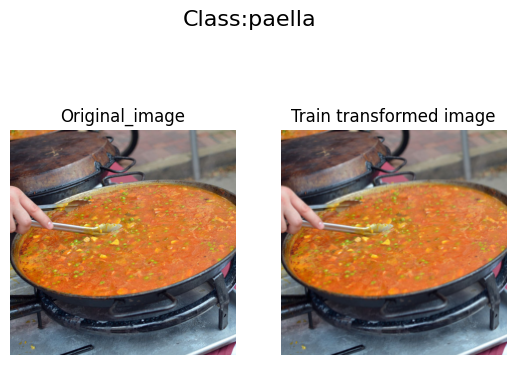

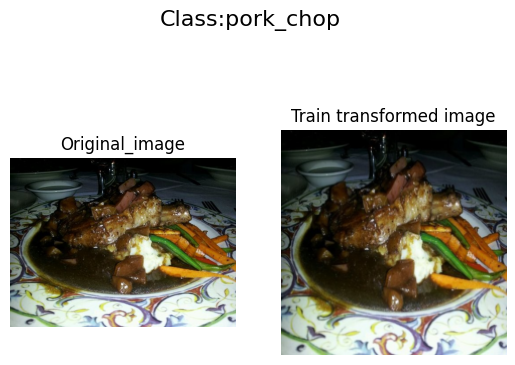

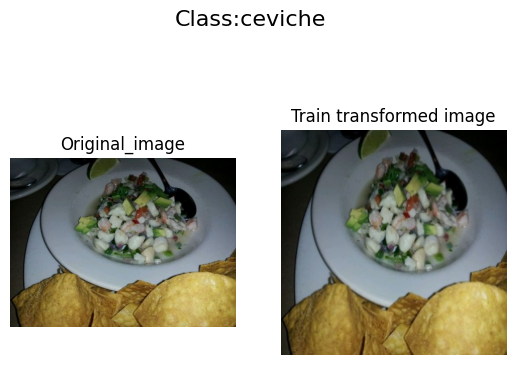

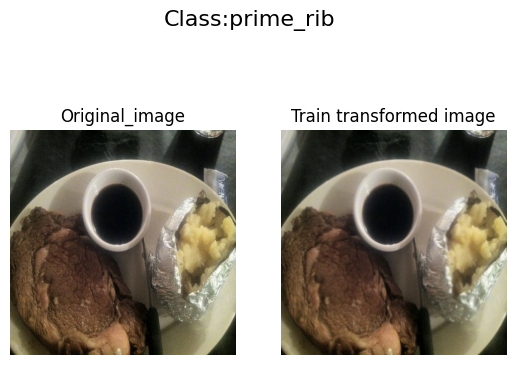

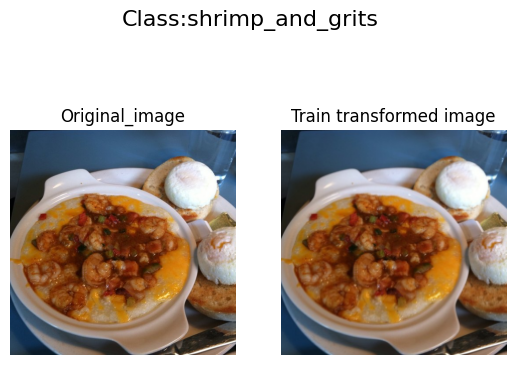

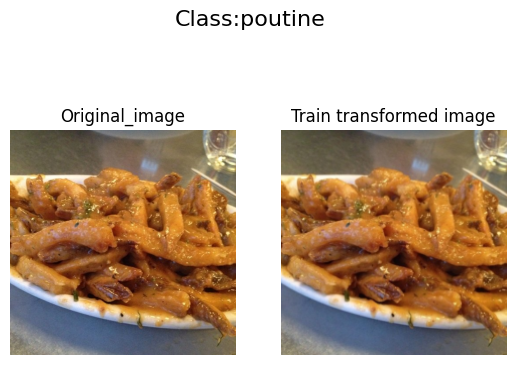

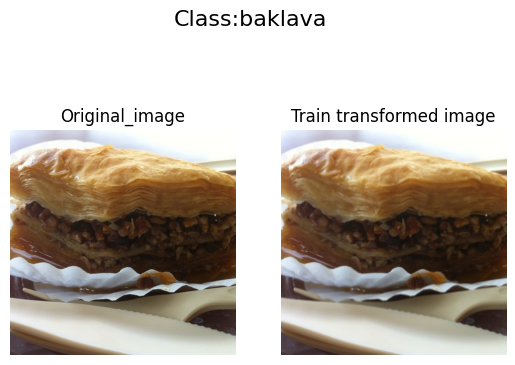

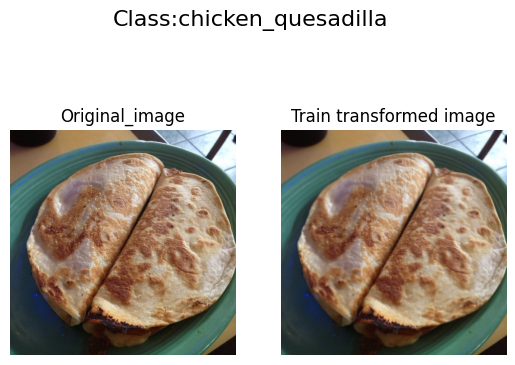

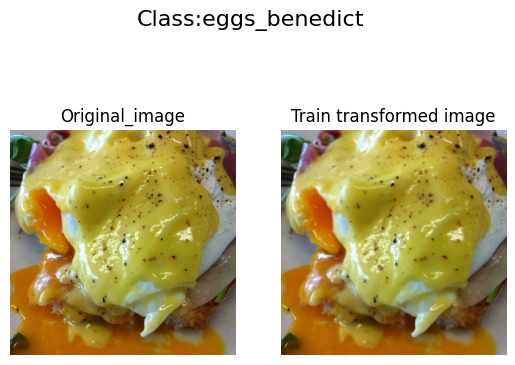

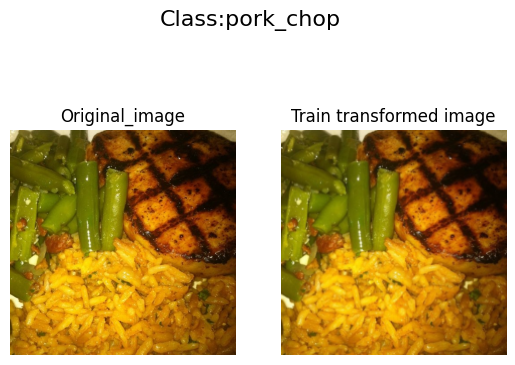

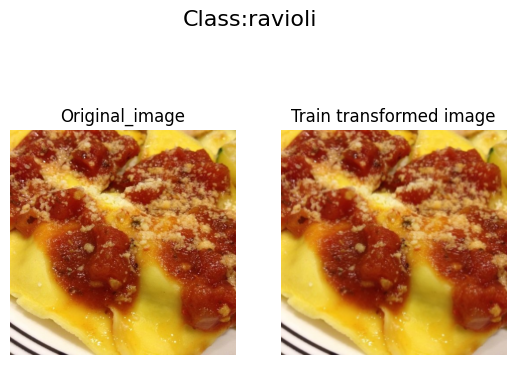

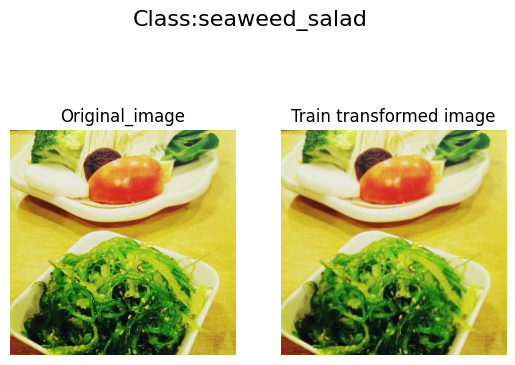

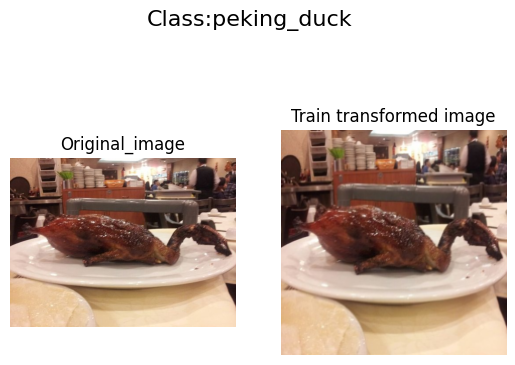

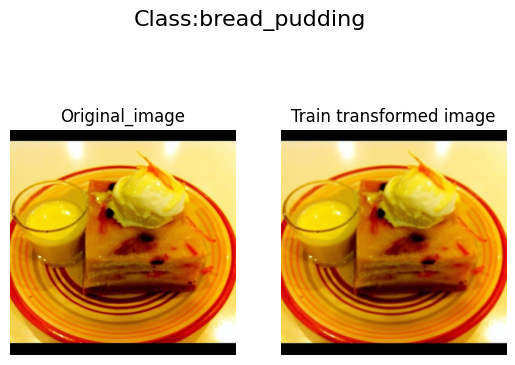

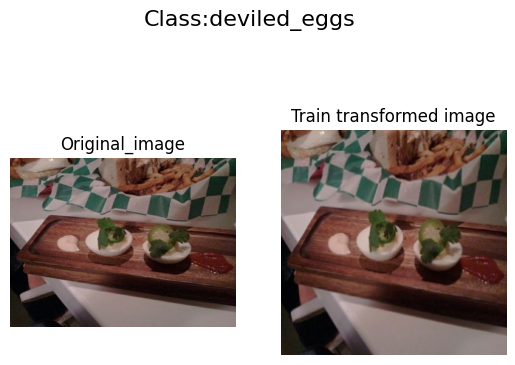

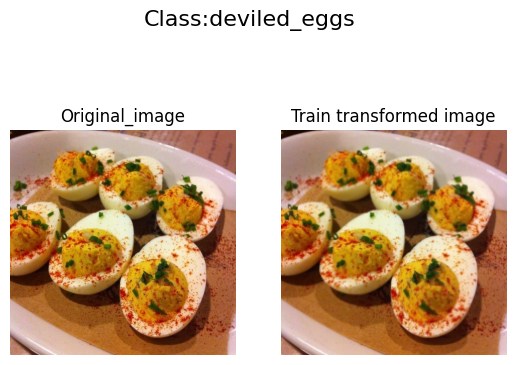

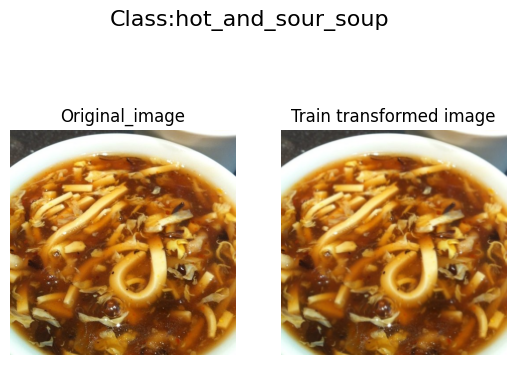

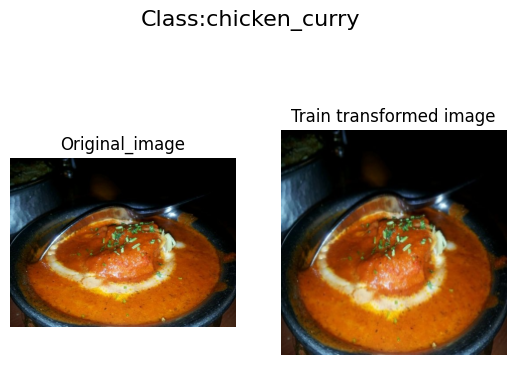

In [ ]:
# Let's check transformations on dataset
def transformed_img_plot(img_paths, transform):
  random.seed(42)
  random_image_paths = random.sample(img_paths, k=20)
  for image_paths in random_image_paths:
    with Image.open(image_paths) as f:
      fig, ax = plt.subplots(1,2)
      ax[0].imshow(f)
      ax[0].set_title("Original_image")
      ax[0].axis('off')

      transformed_img = train_transform(f).permute(1,2,0)
      ax[1].imshow(transformed_img)
      ax[1].set_title("Train transformed image")
      ax[1].axis("off")

      fig.suptitle(f'Class:{image_paths.parent.stem}', fontsize = 16)

transformed_img_plot(image_path_list, train_transform)


In [ ]:
# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir,
                                     transform=train_transform)

test_dataset = datasets.ImageFolder(root=test_dir,
                                    transform=test_transform)

In [ ]:
train_dataset, test_dataset

(Dataset ImageFolder
     Number of datapoints: 75750
     Root location: data/food101/train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 25250
     Root location: data/food101/test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [ ]:
# Create train and test dataloaders
torch.manual_seed(42)
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=32,
                              shuffle=True,
                              num_workers=os.cpu_count())

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=32,
                             shuffle=False,
                             num_workers=os.cpu_count())

In [ ]:
img, label = next(iter(train_dataloader))
img.shape, label.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [ ]:
# Construct Pytorch model for food101 -- AlexNet

class Food_101(nn.Module):
  def __init__(self):
    super().__init__()
    self.block_1 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2)
    )

    self.block_2 = nn.Sequential(
        nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2)

    )

    self.block_3 = nn.Sequential(
        nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2)
    )

    self.avg_pool = nn.AdaptiveAvgPool2d((6,6))

    self.block_4 = nn.Sequential(
        nn.Flatten(),
        nn.Linear(6*6*256, 4096),
        nn.ReLU(),
        nn.Linear(4096,4096),
        nn.ReLU(),
        nn.Linear(4096, 101) # Food101 has 101 classes
    )

  def forward(self,x):
    x = self.block_1(x)
    x = self.block_2(x)
    x = self.block_3(x)
    x = self.avg_pool(x)
    x = self.block_4(x)
    return x


In [ ]:
alex_model = Food_101().to(device)
alex_model

Food_101(
  (block_1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_3): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avg_pool): AdaptiveAvgPool2d(output_size=(6, 6))
  (block_4): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU()
    (

In [ ]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=alex_model.parameters(), lr=0.001)

In [ ]:
%%time

def train_and_test(model,
                   NUM_EPOCHS,
                   optimizer,
                   loss_fn,
                   train_dataloader,
                   test_dataloader,
                   device): # Add device as an argument
  torch.manual_seed(42)
  epochs = NUM_EPOCHS

  # Move model to the target device
  model.to(device)

  for epoch in tqdm(range(epochs)):
      # Training phase
      train_loss = 0
      train_correct = 0
      total_train = 0
      model.train()

      for batch, (X, y) in enumerate(train_dataloader):
          X, y = X.to(device), y.to(device)
          y_pred = model(X)

          loss = loss_fn(y_pred, y)
          train_loss += loss.item()

          # Calculate accuracy
          preds = torch.argmax(y_pred, dim=1)
          train_correct += (preds == y).sum().item()
          total_train += y.size(0)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          if batch % 400 == 0:
              print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

      train_loss /= len(train_dataloader)
      train_acc = 100 * train_correct / total_train

      # Evaluation phase
      test_loss = 0
      test_correct = 0
      total_test = 0
      model.eval()

      with torch.inference_mode():
          for batch, (X, y) in enumerate(test_dataloader):
              X, y = X.to(device), y.to(device)
              test_pred = model(X)
              test_loss += loss_fn(test_pred, y).item()

              preds = torch.argmax(test_pred, dim=1)
              test_correct += (preds == y).sum().item()
              total_test += y.size(0)

      test_loss /= len(test_dataloader)
      test_acc = 100 * test_correct / total_test

      print(f"\nEpoch {epoch+1} | "
            f"Train Loss: {train_loss:.5f}, Train Acc: {train_acc:.2f}% | "
            f"Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%\n")

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.2 µs


## Transfer Learning

In [ ]:
efficientnet_weigts = torchvision.models.EfficientNet_B0_Weights.DEFAULT
efficientnet_transform = efficientnet_weigts.transforms()
efficientnet_model = torchvision.models.efficientnet_b0(weights=efficientnet_weigts)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 69.4MB/s]


In [ ]:
# Install torchinfo if it's not available

try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(efficientnet_model,
        input_size = (32, 3, 224, 224),
        col_names = ["input_size", "output_size", "num_params", "kernel_size", "trainable"],
        col_width = 25,
        row_settings = ['var_names']
        )

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Kernel Shape              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]         [32, 1000]                --                        --                        True
├─Sequential (features)                                      [32, 3, 224, 224]         [32, 1280, 7, 7]          --                        --                        True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]         [32, 32, 112, 112]        --                        --                        True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]         [32, 32, 112, 112]        864                       [3, 3]                    True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]        [32, 32, 112, 112]        64                        --    

In [ ]:
augumented_train_transforms = transforms.Compose([
    transforms.TrivialAugmentWide(),
    efficientnet_transform
])

test_transforms = efficientnet_transform

In [ ]:
from pathlib import Path
data_dir = Path("data")
train_data = datasets.Food101(root=data_dir,
                              split="train",
                              transform=augumented_train_transforms,
                              download=True)
test_data = datasets.Food101(root=data_dir,
                             split="test",
                             transform=test_transforms,
                             download=True)

100%|██████████| 5.00G/5.00G [03:45<00:00, 22.1MB/s]


In [ ]:
import os
train_aug_dataloader = DataLoader(dataset=train_data,
                                  shuffle=True,
                                  num_workers=os.cpu_count(),
                                  batch_size=32)
test_aug_dataloader = DataLoader(dataset=test_data,
                                  shuffle=False,
                                  num_workers=os.cpu_count(),
                                  batch_size=32)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(efficientnet_model.parameters(), lr=1e-4)

In [ ]:
train_and_test(model=efficientnet_model,
               NUM_EPOCHS=5,
               optimizer=optimizer,
               loss_fn=loss_fn,
               train_dataloader=train_aug_dataloader,
               test_dataloader=test_aug_dataloader,
               device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Looked at 0/75750 samples
Looked at 12800/75750 samples
Looked at 25600/75750 samples
Looked at 38400/75750 samples
Looked at 51200/75750 samples
Looked at 64000/75750 samples


 20%|██        | 1/5 [15:04<1:00:16, 904.17s/it]


Epoch 1 | Train Loss: 2.45148, Train Acc: 44.64% | Test Loss: 0.93552, Test Acc: 74.45%

Looked at 0/75750 samples
Looked at 12800/75750 samples
Looked at 25600/75750 samples
Looked at 38400/75750 samples
Looked at 51200/75750 samples
Looked at 64000/75750 samples


 40%|████      | 2/5 [29:40<44:24, 888.04s/it]  


Epoch 2 | Train Loss: 1.32916, Train Acc: 65.62% | Test Loss: 0.70967, Test Acc: 80.17%

Looked at 0/75750 samples
Looked at 12800/75750 samples
Looked at 25600/75750 samples
Looked at 38400/75750 samples
Looked at 51200/75750 samples
Looked at 64000/75750 samples


 60%|██████    | 3/5 [44:08<29:17, 878.93s/it]


Epoch 3 | Train Loss: 1.07214, Train Acc: 71.77% | Test Loss: 0.61981, Test Acc: 82.70%

Looked at 0/75750 samples
Looked at 12800/75750 samples
Looked at 25600/75750 samples
Looked at 38400/75750 samples
Looked at 51200/75750 samples
Looked at 64000/75750 samples


 80%|████████  | 4/5 [58:05<14:21, 861.99s/it]


Epoch 4 | Train Loss: 0.91047, Train Acc: 75.71% | Test Loss: 0.59128, Test Acc: 83.49%

Looked at 0/75750 samples
Looked at 12800/75750 samples
Looked at 25600/75750 samples
Looked at 38400/75750 samples
Looked at 51200/75750 samples
Looked at 64000/75750 samples


100%|██████████| 5/5 [1:11:54<00:00, 862.86s/it]


Epoch 5 | Train Loss: 0.80183, Train Acc: 78.27% | Test Loss: 0.57527, Test Acc: 83.72%



We achieved an accuracy of 83.72% in just 5 epochs; training for more epochs is likely to further improve the accuracy